<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/25_august_2021_fixes/C4/W4/assignment/C4_W4_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

zsh:1: command not found: wget


Download dataset from [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

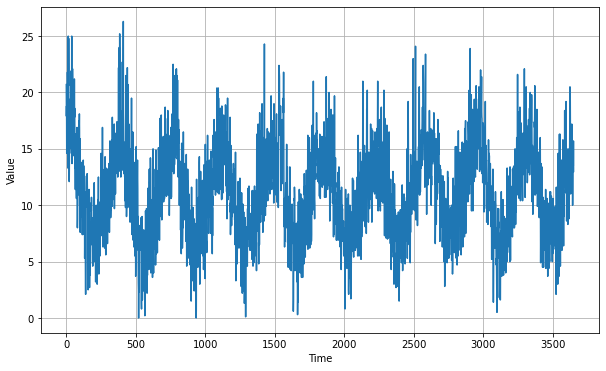

In [7]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


2022-03-21 13:40:36.601261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 13:40:36.601431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100


2022-03-21 13:40:37.880006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-21 13:40:39.365803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:40:39.844173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:40:41.002469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:40:43.480564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:40:44.440789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 163ms/step - loss: 59.3274 - mae: 59.8274 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 48ms/step - loss: 55.9139 - mae: 56.4138 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 40ms/step - loss: 50.7004 - mae: 51.2003 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 44.3750 - mae: 44.8748 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 38ms/step - loss: 37.1354 - mae: 37.6350 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 39ms/step - loss: 28.9919 - mae: 29.4912 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 39ms/step - loss: 20.0116 - mae: 20.5095 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 38ms/step - loss: 11.6459 - mae: 12.1361 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 39ms/step - loss: 8.2622 - mae: 8.7492 - lr

10/10 [==============================] - 0s 39ms/step - loss: 2.8240 - mae: 3.2927 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 1s 46ms/step - loss: 3.8187 - mae: 4.3024 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 0s 40ms/step - loss: 3.5936 - mae: 4.0701 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 1s 42ms/step - loss: 4.5092 - mae: 4.9956 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 1s 42ms/step - loss: 4.2512 - mae: 4.7362 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 0s 39ms/step - loss: 3.6570 - mae: 4.1382 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 0s 42ms/step - loss: 4.1336 - mae: 4.6196 - lr: 7.9433e-05
Epoch 80/100
10/10 [==============================] - 1s 42ms/step - loss: 4.1789 - mae: 4.6655 - lr: 8.9125e-05
Epoch 81/100
10/10 [==============================] - 0s 40ms/step - loss: 4.4973 - mae: 4.9835 - lr: 1.0000e

(1e-08, 0.0001, 0.0, 60.0)

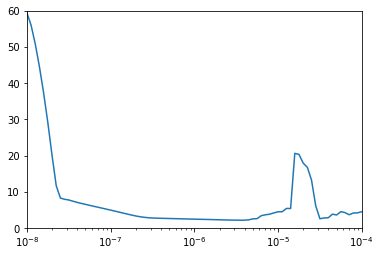

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150


2022-03-21 13:41:37.809735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:41:38.132536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:41:38.428692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:41:38.873966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:41:39.149609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 5s 64ms/step - loss: 18.6313 - mae: 19.1271
Epoch 2/150
25/25 [==============================] - 1s 43ms/step - loss: 11.1382 - mae: 11.6345
Epoch 3/150
25/25 [==============================] - 1s 40ms/step - loss: 4.7089 - mae: 5.1900
Epoch 4/150
25/25 [==============================] - 1s 37ms/step - loss: 2.1893 - mae: 2.6482
Epoch 5/150
25/25 [==============================] - 1s 36ms/step - loss: 1.9604 - mae: 2.4152
Epoch 6/150
25/25 [==============================] - 1s 38ms/step - loss: 1.8723 - mae: 2.3262
Epoch 7/150
25/25 [==============================] - 1s 37ms/step - loss: 1.8268 - mae: 2.2792
Epoch 8/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7749 - mae: 2.2269
Epoch 9/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7496 - mae: 2.2001
Epoch 10/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7109 - mae: 2.1614
Epoch 11/150
25/25 [==============================] - 1s 

25/25 [==============================] - 1s 35ms/step - loss: 1.4771 - mae: 1.9162
Epoch 87/150
25/25 [==============================] - 1s 35ms/step - loss: 1.4783 - mae: 1.9176
Epoch 88/150
25/25 [==============================] - 1s 37ms/step - loss: 1.4755 - mae: 1.9137
Epoch 89/150
25/25 [==============================] - 1s 36ms/step - loss: 1.4751 - mae: 1.9137
Epoch 90/150
25/25 [==============================] - 1s 35ms/step - loss: 1.4759 - mae: 1.9145
Epoch 91/150
25/25 [==============================] - 1s 37ms/step - loss: 1.4709 - mae: 1.9089
Epoch 92/150
25/25 [==============================] - 1s 37ms/step - loss: 1.4727 - mae: 1.9110
Epoch 93/150
25/25 [==============================] - 1s 36ms/step - loss: 1.4748 - mae: 1.9135
Epoch 94/150
25/25 [==============================] - 1s 38ms/step - loss: 1.4754 - mae: 1.9146
Epoch 95/150
25/25 [==============================] - 1s 43ms/step - loss: 1.4807 - mae: 1.9203
Epoch 96/150
25/25 [==============================] -

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


2022-03-21 13:44:14.142521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:44:14.236119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:44:14.332827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


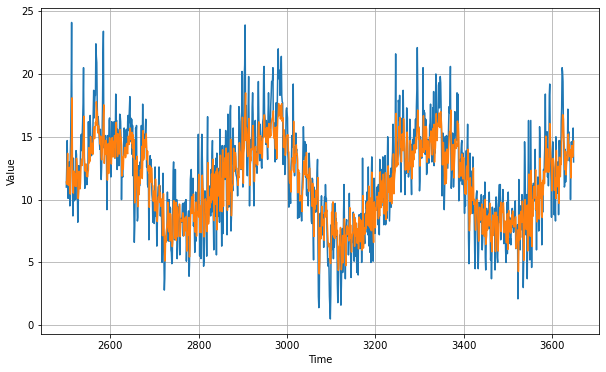

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8154743

In [17]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.395377 11.23146  12.545064 ... 13.423451 13.441445 14.65808 ]
